In [25]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import pandas as pd

#Read input data
train_data = pd.read_csv('/content/drive/MyDrive/ML/housing-prices-ml-project/data/processed/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/ML/housing-prices-ml-project/data/processed/test.csv')


In [28]:
# Specify features and target
X_train = train_data.drop(columns=["Id", "SalePrice"])
Y_train = train_data['SalePrice']

X_test = test_data.drop(columns=["Id"])

## XGBoost

In [29]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize XGBoost regressor
model = XGBRegressor(
    max_depth=3,
    n_estimators=1767,         # equivalent to iterations/max_iter
    learning_rate=0.027,
    min_child_weight=9.869,
    random_state=42,
    subsample=0.6539999999999999,
    colsample_bytree=0.733,
)

# K-Fold CV for regression
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, Y_train, cv=cv)

# Calculate metrics
mse = mean_squared_error(Y_train, y_pred_cv)
r2 = r2_score(Y_train, y_pred_cv)
rmse = np.sqrt(mse)  # Compute RMSE
print(f"CV Root Mean Squared Error: {rmse:.3f}")
print("Cross-validated R²:", round(r2, 3))

# Calculate cross-validated scores
mse_scores = -cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)  # RMSE per fold
r2_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='r2')
print("Max CV RMSE:", round(rmse_scores.max(), 3))
print("Min CV RMSE:", round(rmse_scores.min(), 3))
print("Max CV R²:", round(r2_scores.max(), 3))
print("Min CV R²:", round(r2_scores.min(), 3))

# Retrain on the full training set
model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = model.predict(X_test)


CV Root Mean Squared Error: 27841.426
Cross-validated R²: 0.877
Max CV RMSE: 36076.864
Min CV RMSE: 20967.158
Max CV R²: 0.918
Min CV R²: 0.744


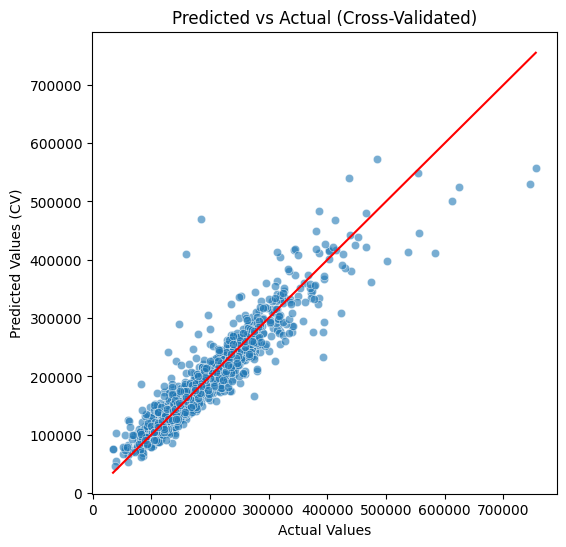

In [31]:
# Predicted vs Actual (CV)
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_train, y=y_pred_cv, alpha=0.6)
sns.lineplot(x=[Y_train.min(), Y_train.max()],
             y=[Y_train.min(), Y_train.max()],
             color="red")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values (CV)")
plt.title("Predicted vs Actual (Cross-Validated)")
plt.show()

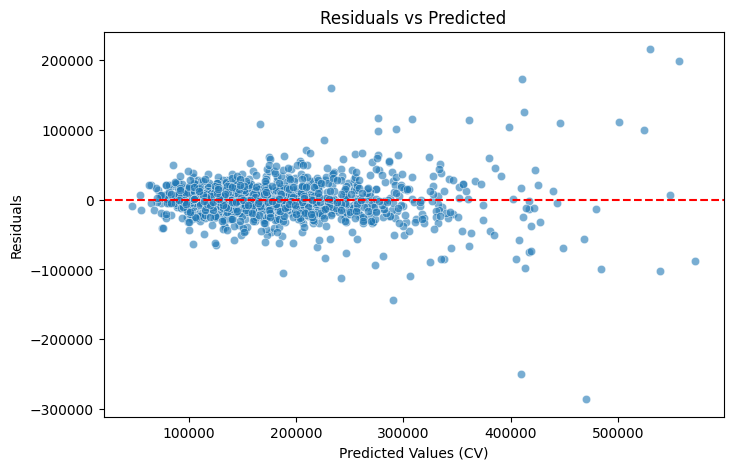

In [32]:
# Residual Plot
residuals = Y_train - y_pred_cv
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_cv, y=residuals, alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values (CV)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

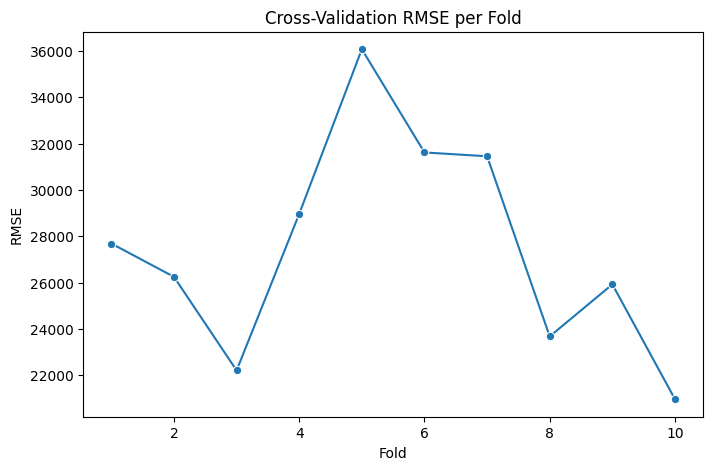

In [33]:
# Cross-Validation RMSE Distribution
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(rmse_scores)+1), y=rmse_scores, marker="o")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Cross-Validation RMSE per Fold")
plt.show()


## lightgbm

In [34]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize LightGBM Regressor with tuned parameters
model = LGBMRegressor(
    n_estimators=1000,      # more boosting rounds
    learning_rate=0.05,     # slower, more stable learning
    num_leaves=31,
    max_depth=-1,
    min_child_samples=7,
    max_bin=38,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Get cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, Y_train, cv=cv)

# Evaluate regression metrics
mse = mean_squared_error(Y_train, y_pred_cv)
rmse = np.sqrt(mse)  # Compute RMSE
r2 = r2_score(Y_train, y_pred_cv)
print(f"CV Root Mean Squared Error: {rmse:.3f}")
print(f"Cross-validated R²: {r2:.4f}")

# Calculate cross-validated scores
mse_scores = -cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)  # RMSE per fold
r2_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='r2')
print("Max CV RMSE:", round(rmse_scores.max(), 3))
print("Min CV RMSE:", round(rmse_scores.min(), 3))
print("Max CV R²:", round(r2_scores.max(), 3))
print("Min CV R²:", round(r2_scores.min(), 3))

# Retrain the model on the full training set
model.fit(X_train, Y_train)

# Make predictions
Y_pred = model.predict(X_test)


CV Root Mean Squared Error: 28886.376
Cross-validated R²: 0.8677
Max CV RMSE: 42423.131
Min CV RMSE: 19192.945
Max CV R²: 0.931
Min CV R²: 0.647


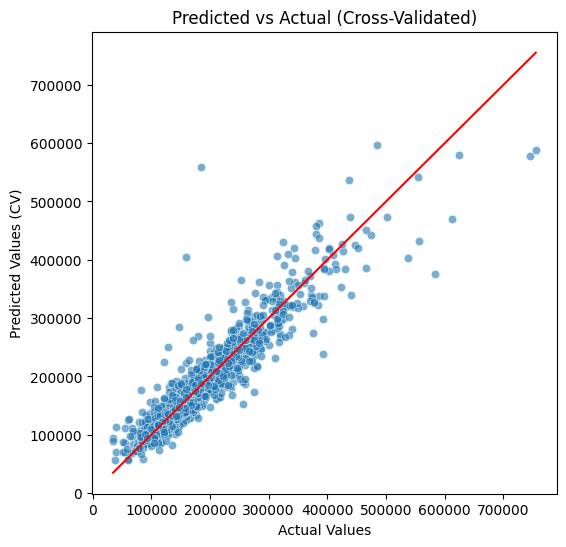

In [35]:
# Predicted vs Actual (CV)
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_train, y=y_pred_cv, alpha=0.6)
sns.lineplot(x=[Y_train.min(), Y_train.max()],
             y=[Y_train.min(), Y_train.max()],
             color="red")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values (CV)")
plt.title("Predicted vs Actual (Cross-Validated)")
plt.show()


Check how close predictions are to the true values.

Points should cluster around the diagonal red line.

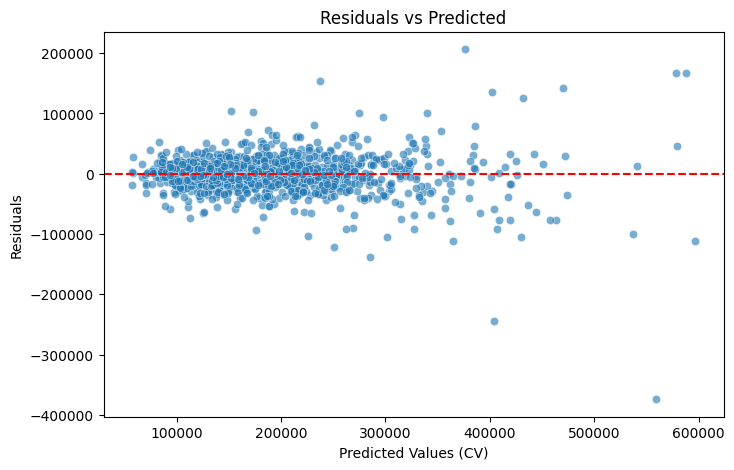

In [36]:
# Residual Plot
residuals = Y_train - y_pred_cv
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_cv, y=residuals, alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values (CV)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

Residuals should be scattered randomly around the red horizontal line (0).

Patterns (curves, slopes) → model is missing structure (e.g., nonlinear effects).

Funnel shape (wider spread at higher predictions) → heteroscedasticity (variance grows with target).

Outliers → large residuals worth investigating.

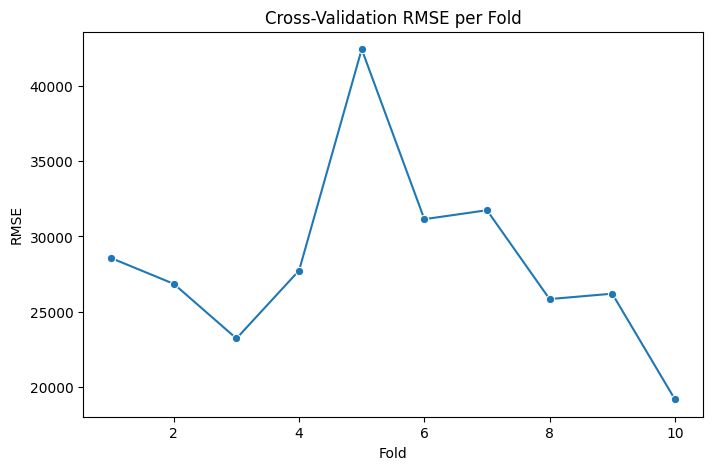

In [37]:
# Cross-Validation RMSE Distribution
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(rmse_scores)+1), y=rmse_scores, marker="o")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Cross-Validation RMSE per Fold")
plt.show()


## catboost

In [38]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [39]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize CatBoost regressor (silent logging with verbose=0)
model = CatBoostRegressor(
    depth=3,
    learning_rate=0.092,
    random_strength=2.534,
    verbose=0,
    l2_leaf_reg=2.055,
    border_count=135,
    bagging_temperature=1.37,
    iterations=1247,
)

# K-Fold CV for regression
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, Y_train, cv=cv)

# Regression metrics
mse = mean_squared_error(Y_train, y_pred_cv)
rmse = np.sqrt(mse)  # Compute RMSE
r2 = r2_score(Y_train, y_pred_cv)
print(f"CV Root Mean Squared Error: {rmse:.3f}")
print(f"CV R² Score: {r2:.3f}")

# Calculate cross-validated scores
mse_scores = -cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)  # RMSE per fold
r2_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='r2')
print("Max CV RMSE:", round(rmse_scores.max(), 3))
print("Min CV RMSE:", round(rmse_scores.min(), 3))
print("Max CV R²:", round(r2_scores.max(), 3))
print("Min CV R²:", round(r2_scores.min(), 3))

# Retrain on the full training set
model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = model.predict(X_test)


CV Root Mean Squared Error: 29230.197
CV R² Score: 0.865
Max CV RMSE: 40885.089
Min CV RMSE: 18601.993
Max CV R²: 0.935
Min CV R²: 0.672


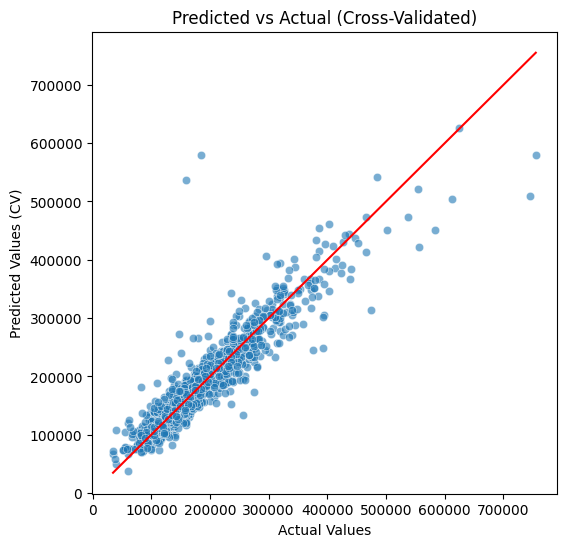

In [40]:
# Predicted vs Actual (CV)
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_train, y=y_pred_cv, alpha=0.6)
sns.lineplot(x=[Y_train.min(), Y_train.max()],
             y=[Y_train.min(), Y_train.max()],
             color="red")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values (CV)")
plt.title("Predicted vs Actual (Cross-Validated)")
plt.show()

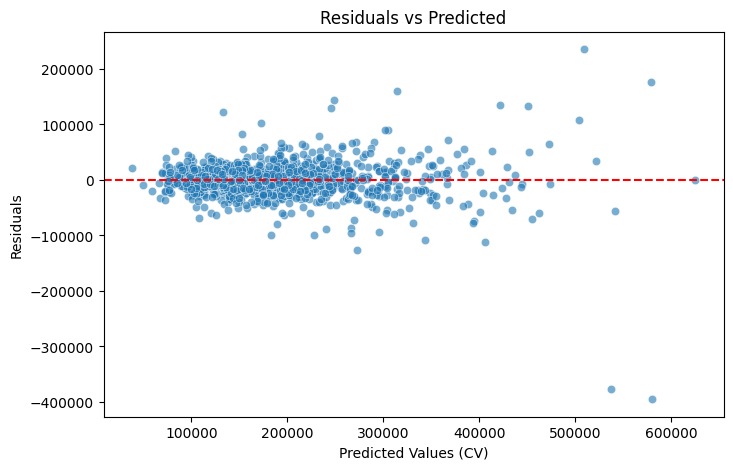

In [41]:
# Residual Plot
residuals = Y_train - y_pred_cv
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_cv, y=residuals, alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values (CV)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

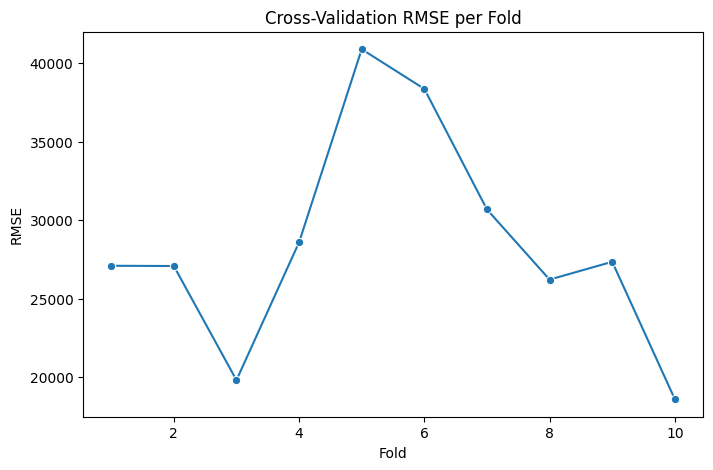

In [42]:
# Cross-Validation RMSE Distribution
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(rmse_scores)+1), y=rmse_scores, marker="o")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Cross-Validation RMSE per Fold")
plt.show()


## Random Forest

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize and fit the Random Forest Regressor with chosen parameters
model = RandomForestRegressor(
    n_estimators=1571,      # Number of trees
    max_depth=13,           # Maximum depth of each tree
    min_samples_split=2,
    min_samples_leaf=2,    # Minimum samples per leaf
    max_features=0.812,
    random_state=42,
    n_jobs=-1              # Use all available cores
)

# Cross-validation setup for regression (no stratification needed)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Get cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, Y_train, cv=cv)

# Calculate and print regression metrics on CV predictions
mse_cv = mean_squared_error(Y_train, y_pred_cv)
r2_cv = r2_score(Y_train, y_pred_cv)
rmse = np.sqrt(mse_cv)  # Compute RMSE
print(f"CV Root Mean Squared Error: {rmse:.3f}")
print(f"Cross-validated R²: {r2_cv:.3f}")

# Calculate cross-validated scores
mse_scores = -cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)  # RMSE per fold
r2_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='r2')
print("Max CV RMSE:", round(rmse_scores.max(), 3))
print("Min CV RMSE:", round(rmse_scores.min(), 3))
print("Max CV R²:", round(r2_scores.max(), 3))
print("Min CV R²:", round(r2_scores.min(), 3))

# Retrain the model on the full training set
model.fit(X_train, Y_train)

# Make predictions on test set
Y_pred = model.predict(X_test)


CV Root Mean Squared Error: 30282.254
Cross-validated R²: 0.855
Max CV RMSE: 43843.27
Min CV RMSE: 18339.738
Max CV R²: 0.94
Min CV R²: 0.623


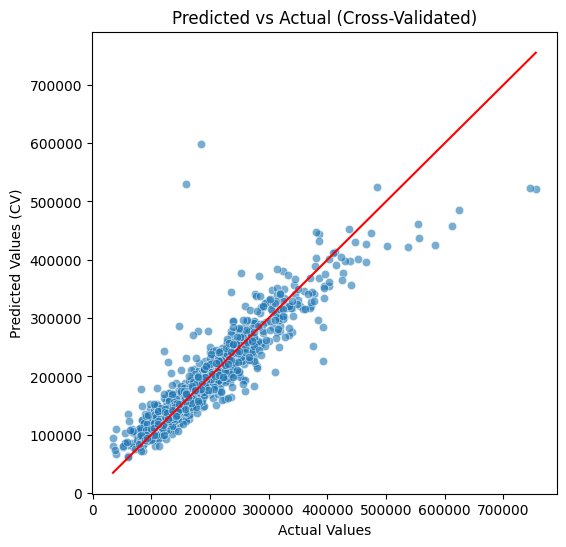

In [44]:
# Predicted vs Actual (CV)
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_train, y=y_pred_cv, alpha=0.6)
sns.lineplot(x=[Y_train.min(), Y_train.max()],
             y=[Y_train.min(), Y_train.max()],
             color="red")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values (CV)")
plt.title("Predicted vs Actual (Cross-Validated)")
plt.show()

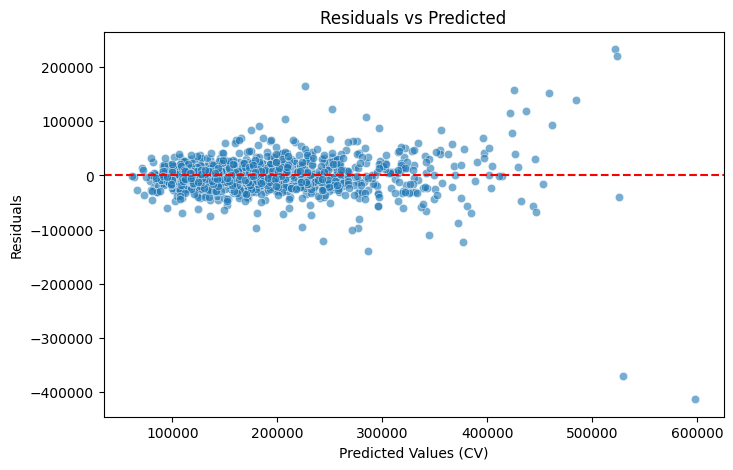

In [45]:
# Residual Plot
residuals = Y_train - y_pred_cv
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_cv, y=residuals, alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values (CV)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

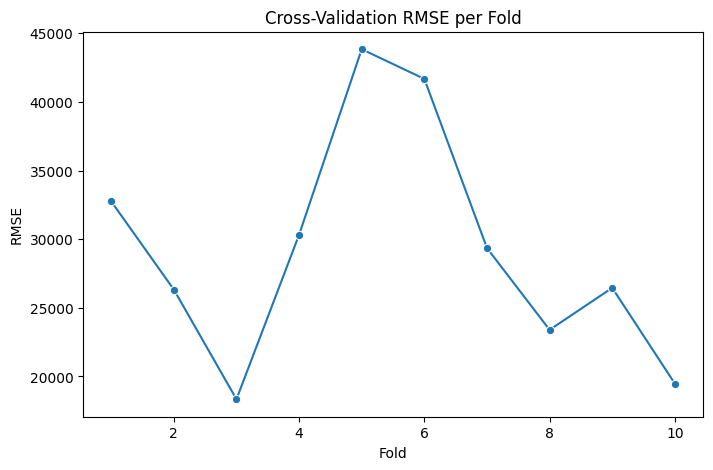

In [46]:
# Cross-Validation RMSE Distribution
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(rmse_scores)+1), y=rmse_scores, marker="o")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Cross-Validation RMSE per Fold")
plt.show()


## HistGradientBoostingClassifier

In [47]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize and fit the model with the best parameters
model = HistGradientBoostingRegressor(
    min_samples_leaf=17,
    max_iter=1163,
    max_depth=2,
    max_bins=209,
    learning_rate=0.093,
    early_stopping=True
)

# K-Fold cross-validation (no stratification needed for regression)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Get cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, Y_train, cv=cv)

# Calculate regression metrics on CV predictions
mse = mean_squared_error(Y_train, y_pred_cv)
r2 = r2_score(Y_train, y_pred_cv)
rmse = np.sqrt(mse)  # Compute RMSE
print(f"CV Root Mean Squared Error: {rmse:.3f}")
print(f"Cross-validated R²: {r2:.3f}")

# Calculate cross-validated scores
mse_scores = -cross_val_score(model, X_train, Y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)  # RMSE per fold
r2_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='r2')
print("Max CV RMSE:", round(rmse_scores.max(), 3))
print("Min CV RMSE:", round(rmse_scores.min(), 3))
print("Max CV R²:", round(r2_scores.max(), 3))
print("Min CV R²:", round(r2_scores.min(), 3))

# Retrain the model on the full training set
model.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = model.predict(X_test)


CV Root Mean Squared Error: 31050.184
Cross-validated R²: 0.847
Max CV RMSE: 40144.259
Min CV RMSE: 20612.484
Max CV R²: 0.933
Min CV R²: 0.69


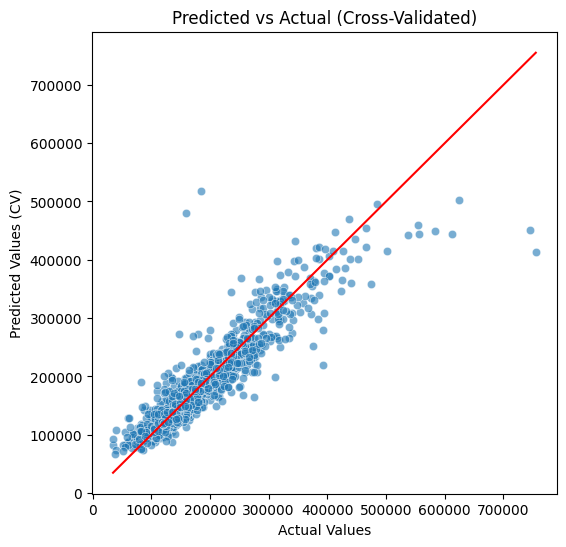

In [48]:
# Predicted vs Actual (CV)
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_train, y=y_pred_cv, alpha=0.6)
sns.lineplot(x=[Y_train.min(), Y_train.max()],
             y=[Y_train.min(), Y_train.max()],
             color="red")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values (CV)")
plt.title("Predicted vs Actual (Cross-Validated)")
plt.show()

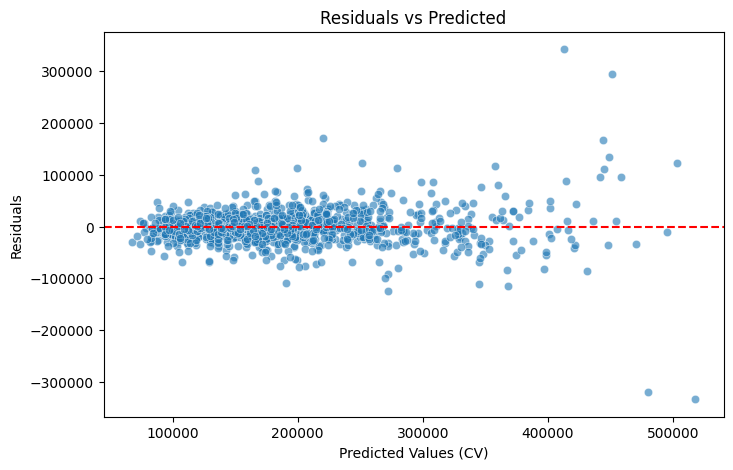

In [49]:
# Residual Plot
residuals = Y_train - y_pred_cv
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_cv, y=residuals, alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values (CV)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

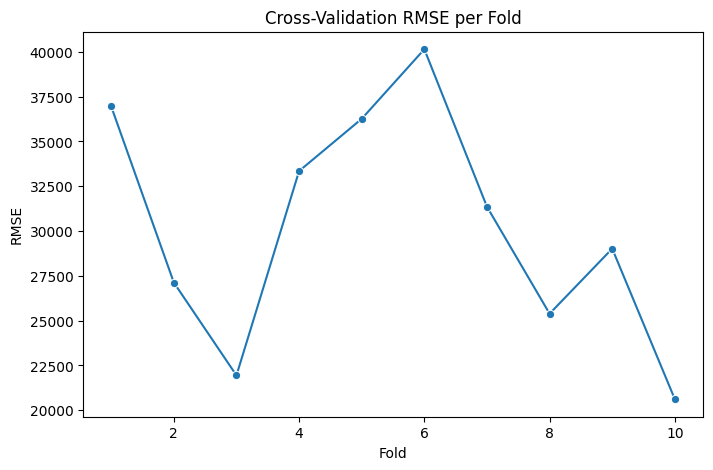

In [50]:
# Cross-Validation RMSE Distribution
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(rmse_scores)+1), y=rmse_scores, marker="o")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Cross-Validation RMSE per Fold")
plt.show()
